For exploration, we should spread the choices as much as possible. Since we do not want to waste the engergy for searching the same region. Thus we consider using the kmeans++ algorithm to spread the whole space. For example, we devide the all 4^6 possible sequences to ~30 clusters, with the spectrum kernel distance. And then select the center of each cluster as the representation to sample with. 

A possible idea is to combine the clustering and successive rejects, where rejects happens in terms of clusters rather than single data points. This solves the problem that the searching space (number of arms) are too large. 

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import math

from codes.kernels_for_GPK import Phi, Spectrum_Kernel, Sum_Spectrum_Kernel
from codes.embedding import Embedding

In [2]:
# create all combos

combos = [] # 20-base
combos_6 = [] # 6-base
combo6_to_idx = {}
labels = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

# to be changed
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'

for i, combo in enumerate(itertools.product(char_sets, repeat= design_len)):
    combos_6.append(''.join(combo))
    combo6_to_idx[''.join(combo)] = i
    combo = pre_design + ''.join(combo) + pos_design
    combos.append(combo)
    labels.append(math.inf)
    
assert len(combos) == len(char_sets) ** design_len
# len(combos)

todesign6_seqs = np.asarray(combos_6) # 6-base
todesign6_data = np.asarray(list(zip(combos_6, labels))) # 6-base

In [3]:
todesign6_seqs

array(['AAAAAA', 'AAAAAG', 'AAAAAC', ..., 'TTTTTG', 'TTTTTC', 'TTTTTT'],
      dtype='<U6')

## Known seq

In [4]:
import pandas as pd 

Path = '../../data/firstRound_4h.csv'

df = pd.read_csv(Path)
known_seq = np.asarray(df['RBS'])

In [5]:
known6_seq = []
known6_seq_idx = []

for seq in known_seq:
    if seq[:7] == 'TTTAAGA' and seq[-7:] == 'TATACAT':
        known6_seq.append(seq[7:13])
        known6_seq_idx.append(combo6_to_idx[seq[7:13]])

In [6]:
known6_seq = np.asarray(list(set(known6_seq)))
known6_seq_idx = np.asarray(list(set(known6_seq_idx)))

## Kmeans

In [7]:
kernel = Spectrum_Kernel(l_list = [2,3,4,5,6], weight_flag = False, padding_flag = False, gap_flag = False)
phi_X, phi_Y = kernel.distance(todesign6_seqs)

(4096, 5456)
(4096, 5456)


In [8]:
#kernel.plot_kernel({'distance': distance})

In [9]:
X = phi_X
n_clusters = 8
y_km = KMeans(n_clusters=n_clusters, init = 'k-means++', random_state=0).fit_predict(X)

In [10]:
y_km

array([6, 6, 6, ..., 4, 4, 4], dtype=int32)

In [11]:
for i in set(y_km[known6_seq_idx]):
    print(i)

0
1
2
3
4
5
6
7


## Dimentional reduction to visualize clustering

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components =2)
tsne_X = tsne.fit_transform(X)

In [13]:
todesign6_seqs.shape

(4096,)

In [14]:
y_km.shape

(4096,)

In [15]:
np.savez('tsne_kmeans_spec', coord = tsne_X, text = todesign6_seqs, ykm = y_km)

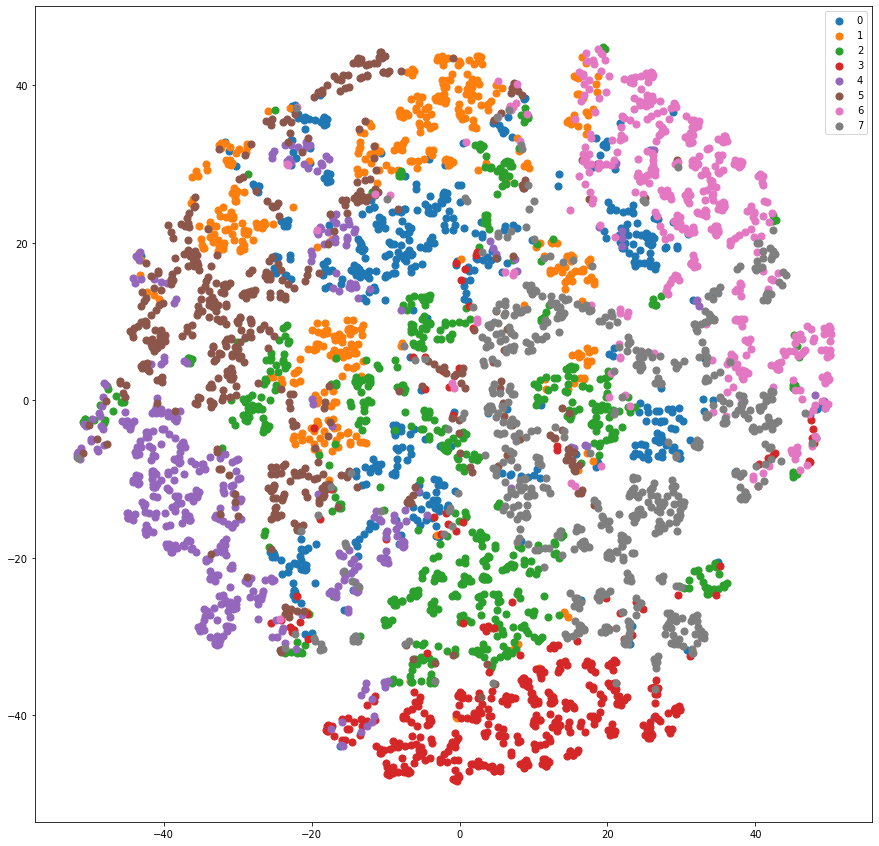

In [16]:
plt.figure(figsize = (15,15))
for i in range(n_clusters):
    plt.scatter(
        tsne_X[y_km == i, 0], tsne_X[y_km == i, 1],
        s=50, 
        label=str(i)
        )
plt.legend()
plt.show()

## K-medoids with [Levenshtein distance](https://en.wikipedia.org/wiki/Damerau%E2%80%93Levenshtein_distance#DNA)

refer to hint [here](https://stackoverflow.com/questions/6293637/can-i-use-k-means-algorithm-on-a-string)

We use a distance metric rather than Euclidean distance. 

In [17]:
from nltk.metrics import distance 
import Pycluster as PC

In [30]:
dist = [distance.edit_distance(todesign6_seqs[i], todesign6_seqs[j]) 
        for i in range(1, len(todesign6_seqs))
        for j in range(0, i)]

labels, error, nfound = PC.kmedoids(dist, nclusters=n_clusters)
cluster = dict()
for word, label in zip(todesign6_seqs, labels):
    cluster.setdefault(label, []).append(word)
for label, grp in cluster.items():
    print(grp)

['AAAAAA', 'AAAAAG', 'AAAAAC', 'AAAAAT', 'AAAAGA', 'AAAATC', 'AAAGAA', 'AAAGAG', 'AAAGAC', 'AAAGAT', 'AAAGGG', 'AAAGGC', 'AAAGGT', 'AAAGCG', 'AAAGCC', 'AAAGCT', 'AAAGTT', 'AAACGA', 'AAACGG', 'AAACGC', 'AAACGT', 'AAATAG', 'AAATAC', 'AAATAT', 'AAATGT', 'AAATTT', 'AAGATA', 'AAGATC', 'AAGGAA', 'AAGGAG', 'AAGGAC', 'AAGGAT', 'AAGGGG', 'AAGGGC', 'AAGGGT', 'AAGGTT', 'AAGCGA', 'AACAAA', 'AACAAG', 'AACAAC', 'AACAAT', 'AACAGA', 'AACAGG', 'AACAGC', 'AACAGT', 'AACATG', 'AACATC', 'AACATT', 'AACGAA', 'AACGAG', 'AACGAC', 'AACGAT', 'AACGGG', 'AACGGC', 'AACGGT', 'AACGCG', 'AACGCC', 'AACGCT', 'AACGTT', 'AACCAA', 'AACCAG', 'AACCAC', 'AACCAT', 'AACCGA', 'AACCGG', 'AACCGC', 'AACCGT', 'AACCCG', 'AACCCC', 'AACCCT', 'AACCTT', 'AACTAA', 'AACTAG', 'AACTAC', 'AACTAT', 'AACTGA', 'AACTGG', 'AACTGC', 'AACTGT', 'AACTCT', 'AACTTT', 'AATAAA', 'AATAAT', 'AATAGA', 'AATAGC', 'AATAGT', 'AATATC', 'AATGAA', 'AATGAG', 'AATGAT', 'AATGGA', 'AATGGG', 'AATGGT', 'AATGTT', 'AATCAA', 'AATCAG', 'AATCAC', 'AATCAT', 'AATCGA', 'AATCGG',

In [31]:
map_dict = {}

for i, j in enumerate(list(set(labels[:4096]))):
    map_dict[j] = i

In [32]:
map_dict

{867: 0, 2505: 1, 843: 2, 3661: 3, 1180: 4, 915: 5, 632: 6, 2844: 7}

In [33]:
y_km_leven = np.zeros_like(np.asarray(labels[:4096]))
for k, label in enumerate(labels[:4096]):
    y_km_leven[k] = map_dict[label]
            
y_km_leven

array([5, 5, 5, ..., 3, 7, 5], dtype=int32)

In [34]:
embed = Embedding(todesign6_seqs)
onehot_X = embed.onehot()

In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components =2)
tsne_X_onehot = tsne.fit_transform(onehot_X)

In [36]:
np.savez('tsne_kmedoids_onehot', coord = tsne_X_onehot, text = todesign6_seqs, ykm = y_km_leven)

In [37]:
np.savez('tsne_kmeans_onehot', coord = tsne_X_onehot, text = todesign6_seqs, ykm = y_km)

In [38]:
np.savez('tsne_kmedoids_spec', coord = tsne_X, text = todesign6_seqs, ykm = y_km_leven)